# Output in zarr (advanced)

Topics:

- Capturing output in memory using the `MemoryStore` of `zarr` ([link](https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.MemoryStore))
- Transferring data from a `MemoryStore` into a directory (via `DirectoryStore`; [link](https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.DirectoryStore)) or a zip file (via `ZipStore`; [link](https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore)).
- Re-chunking output to better align with specific analyses (time vs. spatial filtering).


## A simple flow field

We'll use a Rankine Vortex (https://en.wikipedia.org/wiki/Rankine_vortex) and add some noise to make trajectories interesting.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
np.random.seed(1234)  # let's be reproducible

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 101)
Coordinates:
  * lat      (lat) float64 -20.0 -19.6 -19.2 -18.8 -18.4 ... 18.8 19.2 19.6 20.0
  * lon      (lon) float64 -20.0 -19.6 -19.2 -18.8 -18.4 ... 18.8 19.2 19.6 20.0
Data variables:
    U        (lat, lon) float64 0.4693 0.1444 0.6768 ... -0.2509 -0.1513 -0.425
    V        (lat, lon) float64 -0.4215 -0.3119 -0.2634 ... 0.02258 0.4363

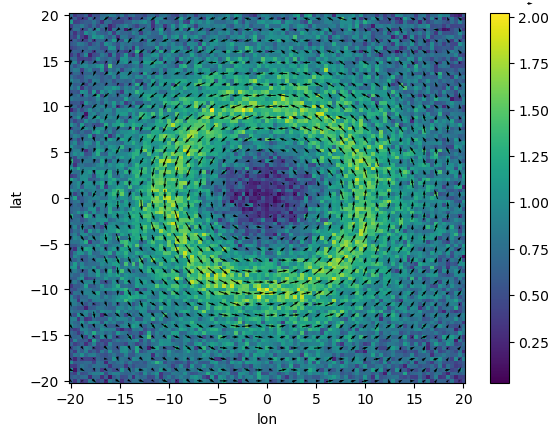

In [3]:
lat = xr.DataArray(np.linspace(-20, 20, 101), dims=("lat",), name="lat")
lon = xr.DataArray(np.linspace(-20, 20, 101), dims=("lon",), name="lon")

# rankine vortex:
Vmax = 1.5
Vnoise = 0.2
phi = np.arctan2(lat, lon)
r = (lat**2 + lon**2) ** 0.5
core_rad = 10
rad_structure = xr.where(r <= core_rad, r / core_rad, core_rad / r)
U_noise = np.random.normal(0, Vnoise, size=r.shape)
V_noise = np.random.normal(0, Vnoise, size=r.shape)

# the dataset
ds_flow_field = xr.Dataset(
    {
        "U": (Vmax * -np.sin(phi) * rad_structure + U_noise).rename("U"),
        "V": (Vmax * np.cos(phi) * rad_structure + V_noise).rename("V"),
    },
    coords={"lat": lat, "lon": lon},
)

display(ds_flow_field)

((ds_flow_field.U**2 + ds_flow_field.V**2) ** 0.5).plot()

(
    ds_flow_field.isel(lon=slice(None, None, 3), lat=slice(None, None, 3)).plot.quiver(
        x="lon", y="lat", u="U", v="V"
    )
);

## The Parcels experiment


In [4]:
from datetime import datetime, timedelta

import numpy as np
import zarr

from parcels import AdvectionRK4, FieldSet, ParticleSet, ScipyParticle

### Create fieldset from Xarray


In [5]:
fieldset = FieldSet.from_xarray_dataset(
    ds_flow_field,
    variables={"U": "U", "V": "V"},
    dimensions={"lat": "lat", "lon": "lon"},
)

### A randomly positioned particleset


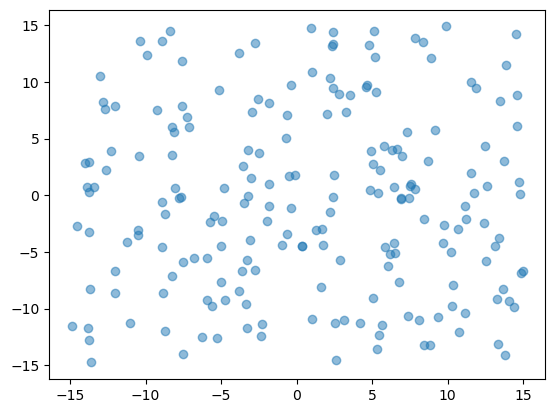

In [6]:
def create_random_pset(
    fieldset=None, lon_range=(-15, 15), lat_range=(-15, 15), number_particles=200
):
    return ParticleSet.from_list(
        fieldset=fieldset,
        pclass=ScipyParticle,
        lon=np.random.uniform(*lon_range, size=(number_particles,)),
        lat=np.random.uniform(*lat_range, size=(number_particles,)),
        time=np.zeros(shape=(number_particles,)),
    )


pset = create_random_pset(fieldset)

plt.plot(pset.lon, pset.lat, "o", alpha=0.5)

### Streaming to an _in-memory_ store


INFO: Output files are stored in <zarr.storage.MemoryStore object at 0x164133550>.
100%|██████████| 1468800.0/1468800.0 [00:06<00:00, 240698.79it/s]


<xarray.Dataset>
Dimensions:     (trajectory: 200, obs: 136)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 128 129 130 131 132 133 134 135
  * trajectory  (trajectory) int64 200 201 202 203 204 ... 395 396 397 398 399
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(200, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ScipyParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        v2.4.2-370-gd0cb4110

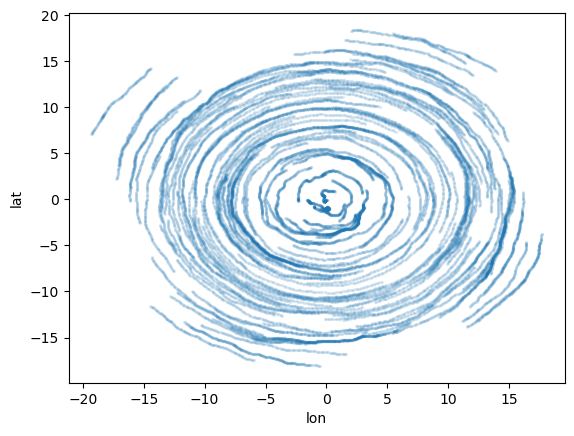

In [7]:
# create fresh particle set
pset = create_random_pset(fieldset)

# create output store and output file
output_memorystore = zarr.storage.MemoryStore()
outputfile = pset.ParticleFile(name=output_memorystore, outputdt=timedelta(hours=3))

# run experiment
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=17),
    dt=timedelta(hours=3),
    output_file=outputfile,
)

# load output
ds_out = xr.open_zarr(output_memorystore)
display(ds_out)

# have a look
ds_out.to_dataframe().plot.scatter(x="lon", y="lat", s=2, alpha=0.1);

## Saving to an other Zarr store


### Directory, without changing chunking


<xarray.Dataset>
Dimensions:     (trajectory: 200, obs: 136)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 128 129 130 131 132 133 134 135
  * trajectory  (trajectory) int64 200 201 202 203 204 ... 395 396 397 398 399
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(200, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ScipyParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        v2.4.2-370-gd0cb4110

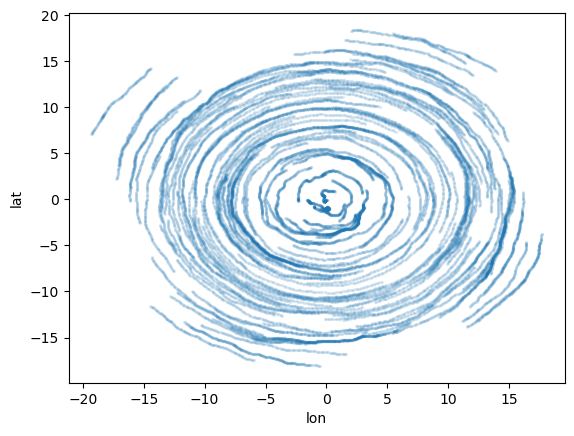

In [8]:
# create store
output_dirstore_name = "zarr_advanced_01.zarr/"
!rm -rf {output_dirstore_name}
output_dirstore = zarr.storage.DirectoryStore(output_dirstore_name)

# copy
zarr.convenience.copy_store(output_memorystore, output_dirstore)
output_dirstore.close()

# have a quick look
ds_out = xr.open_zarr(output_dirstore_name)
display(ds_out)
ds_out.to_dataframe().plot.scatter(x="lon", y="lat", s=2, alpha=0.1);

### Zipfile, without changing chunking


<xarray.Dataset>
Dimensions:     (trajectory: 200, obs: 136)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 128 129 130 131 132 133 134 135
  * trajectory  (trajectory) int64 200 201 202 203 204 ... 395 396 397 398 399
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] dask.array<chunksize=(200, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(200, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ScipyParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        v2.4.2-370-gd0cb4110

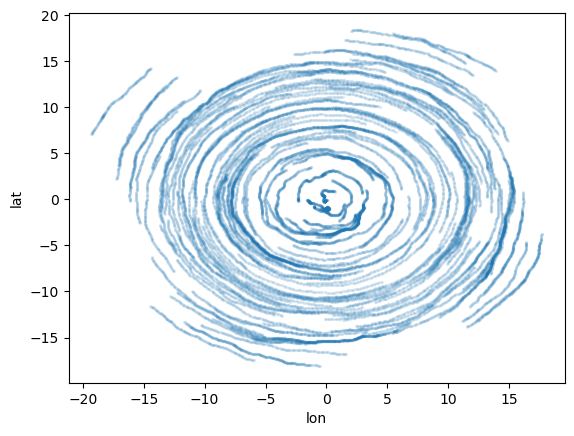

In [9]:
# create store
output_zipstore_name = "zarr_advanced_01.zip"
!rm -f {output_zipstore_name}
output_zipstore = zarr.storage.ZipStore(output_zipstore_name, mode="w")

# copy
zarr.convenience.copy_store(output_memorystore, output_zipstore)
output_zipstore.close()

# have a quick look
ds_out = xr.open_zarr(output_zipstore_name)
display(ds_out)
ds_out.to_dataframe().plot.scatter(x="lon", y="lat", s=2, alpha=0.1);

### Rechunking and saving to new stores


Consider the current chunking (let's load the memory store again):


In [10]:
ds_out_orig = xr.open_zarr(output_memorystore)
display(ds_out_orig.lat.data)
display(ds_out_orig.chunks)

dask.array<open_dataset-lat, shape=(200, 136), dtype=float32, chunksize=(200, 1), chunktype=numpy.ndarray>

Frozen({'trajectory': (200,), 'obs': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)})

So we have one chunk per `obs` slice which covers all trajectories. This is the optimal way of _creating_ the recorded dataset at simulation time, but may not be ideal for, e.g., time filtering.

So let's turn this into a store which only covers 10 trajectories per chunk but 40 time steps:


In [11]:
ds_out_rechunked = ds_out_orig.chunk({"trajectory": 10, "obs": 40})
display(ds_out_rechunked.lat.data)
display(ds_out_rechunked.chunks)

dask.array<rechunk-merge, shape=(200, 136), dtype=float32, chunksize=(10, 40), chunktype=numpy.ndarray>

Frozen({'trajectory': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10), 'obs': (40, 40, 40, 16)})

And of course, we could now save the rechunked data into a zip store or a directory store:


In [12]:
# necessary because of https://github.com/pydata/xarray/issues/4380
for vname, vobj in ds_out_rechunked.data_vars.items():
    if "chunks" in vobj.encoding:
        del vobj.encoding["chunks"]

In [13]:
ds_out_rechunked.to_zarr("zarr_advanced_01_rechunked.zarr/", mode="w")
# new directory store
ds_out_rechunked.to_zarr(
    zarr.storage.ZipStore("zarr_advanced_01_rechunked.zip", mode="w")
);  # new zip store